In [40]:
import networkx as nx
import nibabel as nb
import numpy as np
from scipy import sparse

from niio import loaded

def unweightedadjacency(F, to_dict=True):
    """
    Compute adjacency matrix of surface mesh

    Parameters:
    - - - - -
    F: int, array
        mesh triangles

    Returns:
    - - - -
    A: int, sparse array
        adjacency matrix of surface mesh
    """

    n = F.max()+1

    rows = np.concatenate([F[:, 0], F[:, 0],
                           F[:, 1], F[:, 1],
                           F[:, 2], F[:, 2]])

    cols = np.concatenate([F[:, 1], F[:, 2],
                           F[:, 0], F[:, 2],
                           F[:, 0], F[:, 1]])

    combos = np.column_stack([rows, cols])

    [_, idx] = np.unique(combos, axis=0, return_index=True)
    print('# unique vertices: %i' % (len(idx)))
    A = sparse.csr_matrix(
        (np.ones(len(idx)), (combos[idx, 0], combos[idx, 1])), shape=(n, n))
    
    if to_dict:
        A_dict = {k: [] for k in np.arange(A.shape[0])}
        
        for k in A_dict.keys():
            A_dict[k] = list(sparse.find(A[k])[1])
    
        A = A_dict

    return A

In [50]:
def find_boundaries(index_map, adj_list):

    """
    Method to identify vertices that exist at the boundary of two regions.

    Parameters:
    - - - - -
    index_map: dictionary
        mapping of region names / classes to indices assigned to that class

    adj_list : dictionary
        adjacency list for surface mesh on which label map lives

    Returns:
    - - - -
    boundaries: dict
        mapping of each region / class to a set
        of indices that exist at the boundary of that class.
    """

    boundaries = {k: None for k in index_map.keys()}

    for region, inds in index_map.items():

        binds = []

        for tidx in inds:

            neighbors = set(adj_list[tidx])
            outer = neighbors.difference(set(inds))
            if len(outer) > 0:
                binds.append(tidx)

        boundaries[region] = binds

    return boundaries

In [51]:
def boundaries(label, adj_list, normed=True):
    """
    Compute number of boundary vertices in label map.

    Parameters:
    - - - - -
    label : array
        cortical map
    adjacency : dictionary
        adjacency list
    normed: bool
       return number of boundary vertices, normalized by total number of 
       vertices (i.e. return a FLOAT rather than an INT)
    Returns:
    - - - -
    boundC : int
        number of vertics that exist at parcel boundaries
    """

    idx_map = {k: list(np.where(label == k)[0]) for k in set(label)}
    bmap = find_boundaries(idx_map, adj_list)

    boundC = np.sum([len(k) for k in bmap.values()])

    if normed:
        boundC = boundC / len(label)

    return boundC

In [52]:
label_file = '/Users/kristianeschenburg/Desktop/Data/Labels/Desikan/L.100.aparc.32k_fs_LR.label.gii'
label = nb.load(label_file)
label = label.darrays[0].data

In [55]:
idx_map = {k: list(np.where(label == k)[0]) for k in set(label).difference({-1})}

In [58]:
bound = find_boundaries(adj_list=adj, index_map=idx_map)

In [53]:
bmap = boundaries(label, adj)

In [54]:
bmap

0.1345869752554475

# How to use **ddCRP**:  An example with synthetic data

This notebook is analogous to the documentation contained in the ReadMe.md file.  We begin by importing the necessary modules.  *ddCRP* contains the actual modeling algorithm, *Priors* contains the allowed prior models (Normal-Inverse-Chi-Squared and Normal-Inverse-Wishart), and *synthetic* contains methods for sampling synthetic data.

In [1]:
from ddCRP import ddCRP
from ddCRP import Priors
from ddCRP import synthetic

import numpy as np
np.random.seed(seed=2)

Next, we define some parameters for generating our synthetic data.  In this case, we are sampling our synthetic data from a *Normal-Inverse-Chi-Squared* model:

$$
(\mu,\sigma) \sim NI \chi^{2} (\mu_{0},\kappa_{0}; \nu_{0},\sigma^{2}_{0})
$$

where $\mu_{0}$ and $\kappa_{0}$ are priors on the feature means, while $\nu_{0}$ and $\sigma^{2}_{0}$ are priors on the feature variance.

Here, for each unique label in our synthetic data, we sample $d$ unique means and variances, and then sample feature vectors from a multivariate normal distribution with independent features (a.k.a. diagonal covariance matrix, and hence the Normal-Inverse-Chi-Squared model).

We could just as easily skip the Normal-Inverse-Chi-Squared aspect, and simply define a set of multivariate Normal distributions.  However, in this way, we can see how hyperparameter tuning of our ddCRP model relates to the hyperparameters of our synthetic data model.

In [2]:
# dimensionality of data
d = 5

mu = 0
kappa = 0.01
nu = 70
sigma= 1

Next, we initialize a **SampleSynthetic** object. ```kind=ell``` defines what type of synthetic data we are modeling.  Options for this parmeter include ```['ell', 'stripes', 'face', 'square']```.

In [3]:
synth = synthetic.SampleSynthetic(kind='face', d=d, mu0=0, kappa0=kappa, nu0=nu, sigma0=sigma)
synth.fit()

print('Attributes of synth: \n')
print(list(synth.__dict__.keys()))

Attributes of synth: 

['kind', 'd', 'mu0', 'kappa0', 'nu0', 'sigma0', 'z_', 'adj_list_', 'parcels_', 'params_', 'parcel_features_', 'features_']


We're specifically interested in ```z_```, ```adj_list_```, and ```features_```.  ```z_``` represents the ground truth label map of our synthetic data, ```adj_list_``` is the adjancey list of our samples, and ```features_``` are the multivariate feature vectors of our data.

Next, we initialize our prior model.  In this case, we'll use the **Normal-Inverse-Wishart** prior.  We need to define a multivariate mean vector prior $\bar{\mu_{0}}$, and a prior on the covariance matrix $\bar{\lambda_{0}}$ (for the inverse-Wishart distribution), along with $\kappa_{0}$ and $\nu_{0}$ as above.

In [4]:
mu_bar = np.zeros((d,))
lambda_bar = np.random.rand(d,d) + np.eye(d)

niw = Priors.NIW(mu0=mu_bar,kappa0=kappa,nu0=nu,lambda0=lambda_bar)

Finally, we can initialize our ddCRP model.  We first need to define a "concentration parameter", $\alpha$, that determines how likely points are to create new clusters or join an existing cluster.  We also provide some arguments that govern how many MCMC iterations we want to perform, and how often we want to sample and print out diagnostic information regarding the current state of our model.

In [5]:
alpha = 10

crp = ddCRP.ddCRP(alpha, model=niw, mcmc_passes=15, stats_interval=125)
crp.fit(synth.features_, synth.adj_list_)

Step: 0 Time: -1587250470.4788592 LP: -1064.6868011460178 K: 100 MaxLP: -1064.6868011460178


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

Now we can print out the our ground truth label map, the *maximum-a-posterior* label map (i.e. the label configuration that maximizes the marginal evidence of our feature data, and the intial (essentially random) map that the ddCRP model starts out with.  The actual label values (colors) are arbitrary, and don't convey any special meaning.

Below the images are plots showing the number of clusters, marginal-evidence, and current *MAP*-evidence, each as a function of MCMC iterations (the sampling frequency is determined by the ```stats_interval``` parameter in the ddCRP model instantiation).

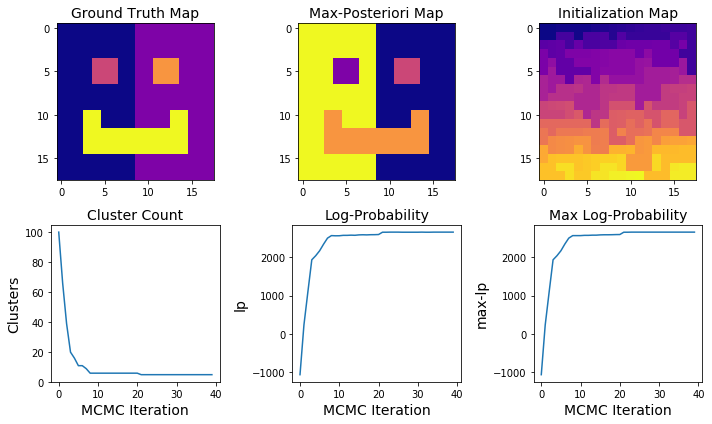

In [6]:
plot = synthetic.plot_synthetic(synth, crp, figsize=(10,6), cmap='plasma');
plot